# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [225]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from sklearn.model_selection import train_test_split

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn import metrics

Прочитаем исходные данные:

In [226]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [227]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


Text(0.5, 1.0, 'Распределение признака VR')

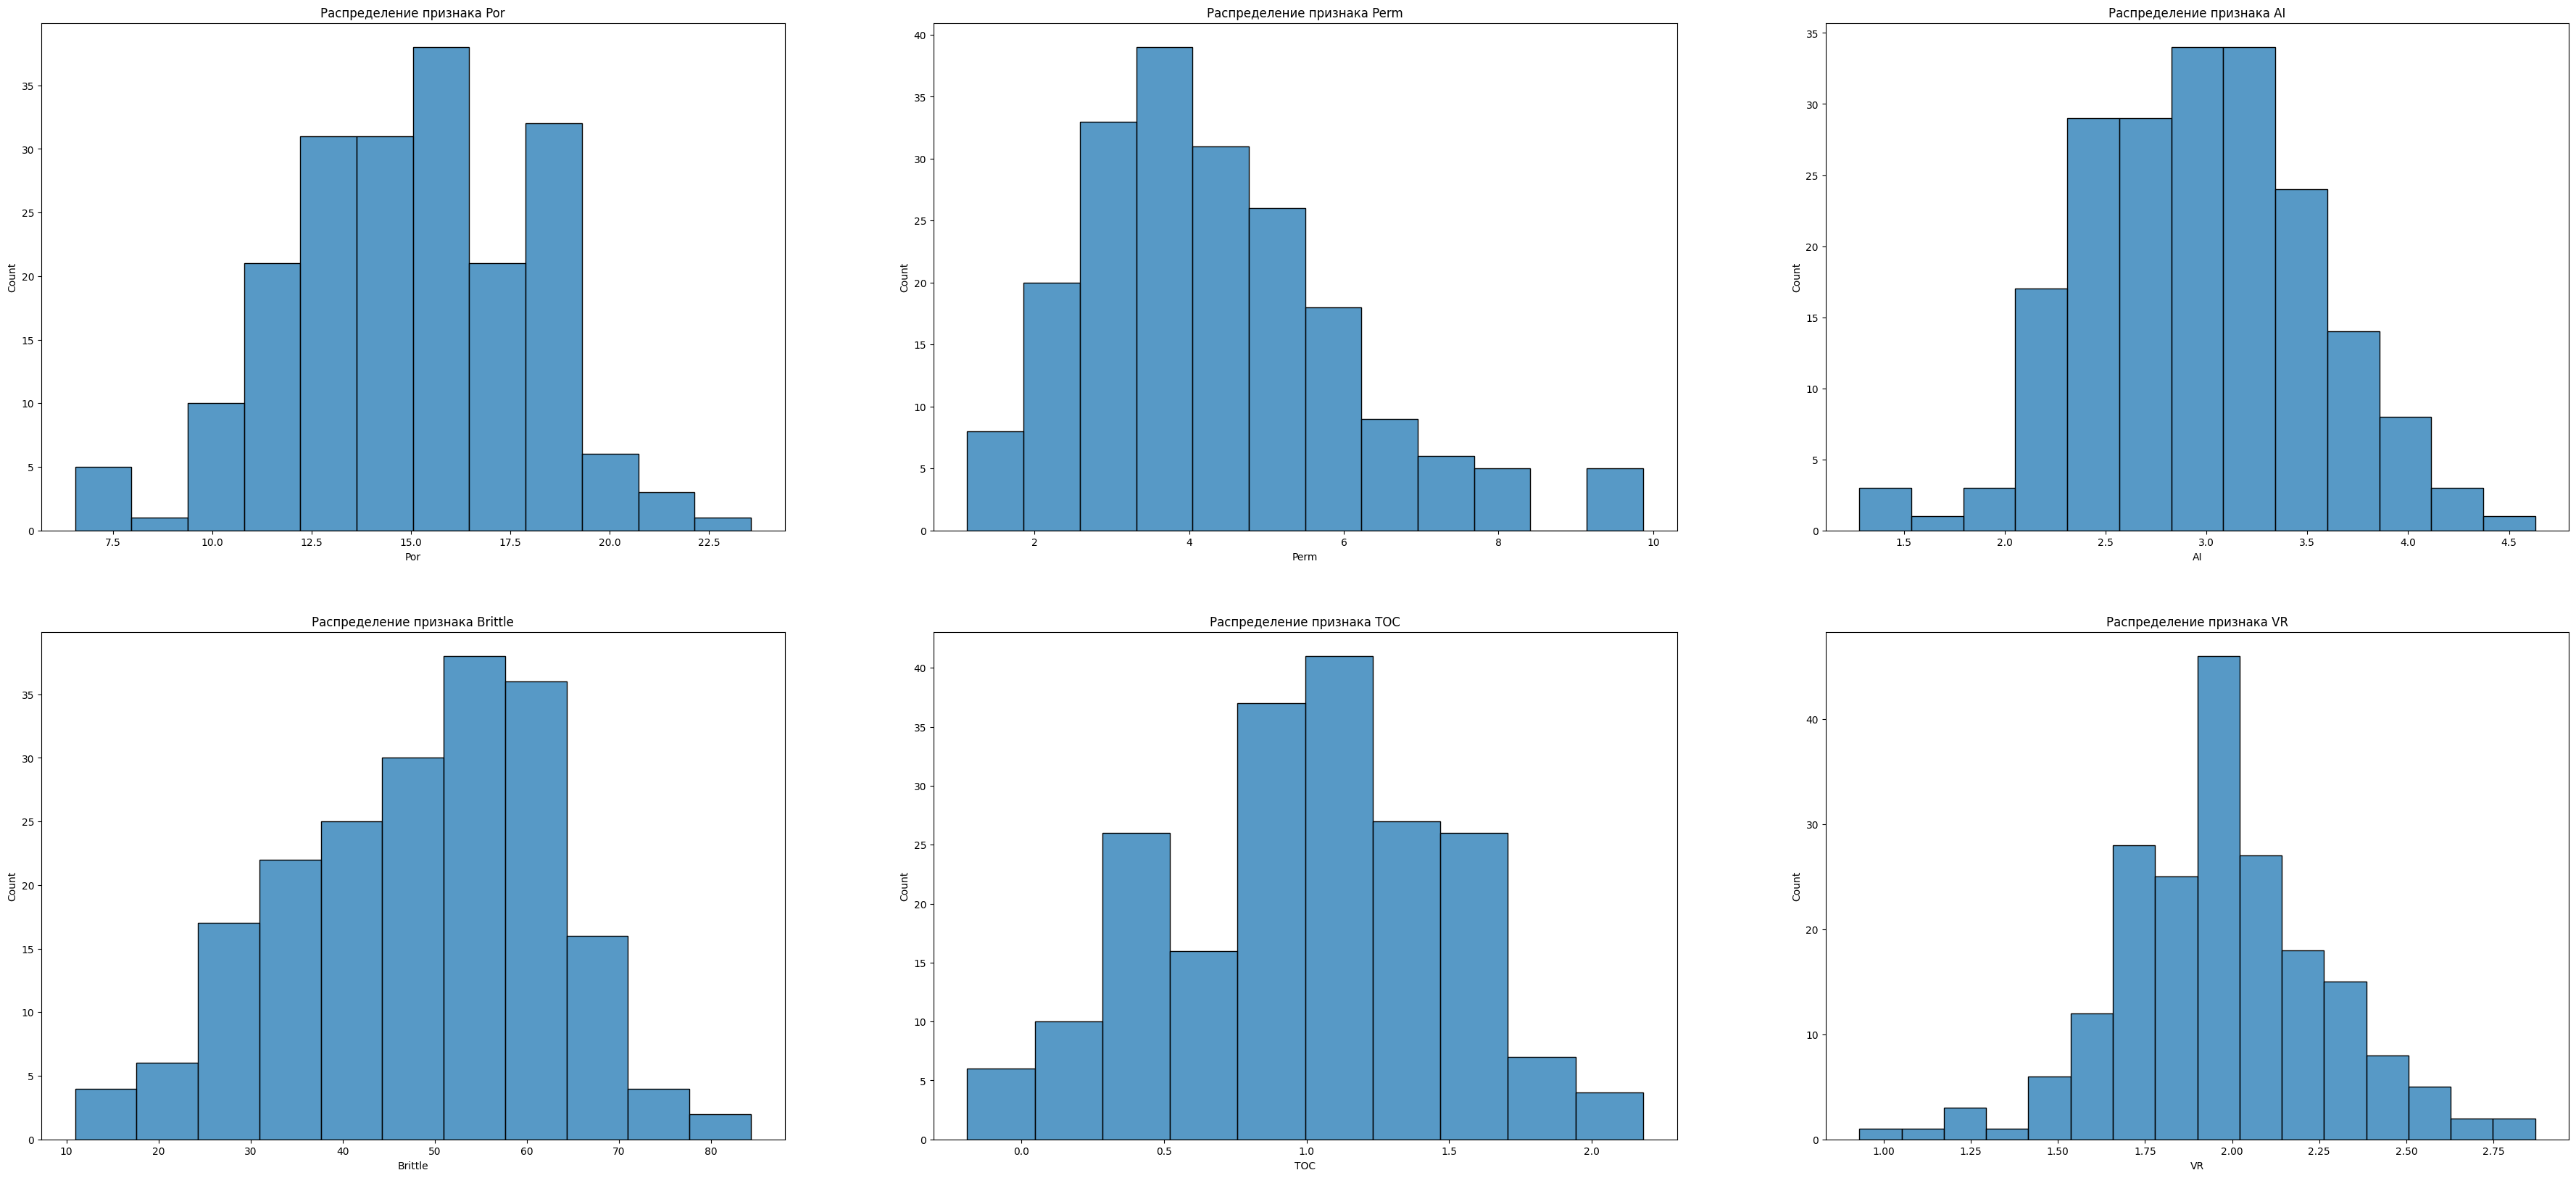

In [228]:
# Ваш код здесь
plt.rcParams.update({
    'figure.titlesize': 24      # Размер общего заголовка
})

# Визуализируем данные - смотрим распределение
fig, axes = plt.subplots(2, 3, figsize=(45, 20))
hist1 = sns.histplot(data['Por'], ax = axes[0,0])
hist2 = sns.histplot(data['Perm'], ax = axes[0,1])
hist3 = sns.histplot(data['AI'], ax = axes[0,2])
hist4 = sns.histplot(data['Brittle'], ax = axes[1,0])
hist5 = sns.histplot(data['TOC'], ax = axes[1,1])
hist5 = sns.histplot(data['VR'], ax = axes[1,2])

axes[0,0].set_title('Распределение признака Por')
axes[0,1].set_title('Распределение признака Perm')
axes[0,2].set_title('Распределение признака AI')
axes[1,0].set_title('Распределение признака Brittle')
axes[1,1].set_title('Распределение признака TOC')
axes[1,2].set_title('Распределение признака VR')

> Визуально, данные распределены нормально (близко к нормальному). Вполним дополнительную проверку с помощью статистического теста

In [229]:
# Выполним проверку распределения данных по методу Шапиро-Уилка
col_names = list(data.columns)

#Словарь с выводом о нормальности/не нормальности по каждому признаку
finish = {}
for i in col_names:
    
    #Вероятность ошибки a = 0.05
    alpha = 0.05
    _, p = stats.shapiro(data[i])
    
    if p <= alpha:
        finish.update({i: 'Распределение не нормальное ({})'.format('p-value = %.3f' % (p))})
    else:
        finish.update({i: 'Распределение нормальное'})
        
for key, value in finish.items():
    print(f"{key}: {value}")

Well: Распределение не нормальное (p-value = 0.000)
Por: Распределение нормальное
Perm: Распределение не нормальное (p-value = 0.000)
AI: Распределение нормальное
Brittle: Распределение нормальное
TOC: Распределение нормальное
VR: Распределение нормальное
Prod: Распределение нормальное


> Как видим, тест подтвердил нормальность распределения большей части признаков. За исключением признаков **Perm** и **Well**

> Логарифмируем признак **Perm** и проверим на нормальность ещё раз.

*Признак **Well** - не информативен, его трогать не будем, впоследствии удалим*

In [230]:
data_log = data.copy()
data_log['Perm'] = np.log(data['Perm']+1)

# проводим тест Шапиро-Уилка
_, p = stats.shapiro(data_log['Perm'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.878
Распределение нормальное


> Все в порядке! теперь признак **Perm** распределён нормально

In [231]:
fig = make_subplots(rows=2, cols=3, 
                   subplot_titles=("Распределение признака Por", 
                                  "Распределение признака Perm", 
                                  "Распределение признака AI",
                                  "Распределение признака Brittle",
                                  "Распределение признака TOC",
                                  "Распределение признака VR"))

# Добавляем боксплоты
fig.add_trace(go.Box(y=data_log['Por'], name="Por"), row=1, col=1)
fig.add_trace(go.Box(y=data_log['Perm'], name="Perm"), row=1, col=2)
fig.add_trace(go.Box(y=data_log['AI'], name="AI"), row=1, col=3)
fig.add_trace(go.Box(y=data_log['Brittle'], name="Brittle"), row=2, col=1)
fig.add_trace(go.Box(y=data_log['TOC'], name="TOC"), row=2, col=2)
fig.add_trace(go.Box(y=data_log['VR'], name="VR"), row=2, col=3)

# Настраиваем общий вид
fig.update_layout(
    title_text="Боксплоты распределения признаков",
    height=1000,
    width=1500,
    showlegend=False,
    title_font_size=24,
    font_size=16
)

# Настраиваем отступы между графиками
fig.update_layout(
    margin=dict(l=50, r=50, t=100, b=50),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

> Визуальная проверка показывает, что имеются выбросы в признаках **Perm, Ai, VR**

> Выполним проверку выбросов в данных признаках с помощью статистических тестов

In [232]:
# Метод сигм - функция
def outliers_z_score(data, feature):
    x = data_log[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    return outliers

In [233]:
# Применим эту функцию к таблице data_log и признакам Perm, AI, VR

outliers_Perm = outliers_z_score(data_log, 'Perm')
print(f'Число выбросов по методу z-отклонения [Perm]: {outliers_Perm.shape[0]}')

outliers_AI = outliers_z_score(data_log, 'AI')
print(f'Число выбросов по методу z-отклонения [AI]: {outliers_AI.shape[0]}')

outliers_VR = outliers_z_score(data_log, 'VR')
print(f'Число выбросов по методу z-отклонения [VR]: {outliers_VR.shape[0]}')

Число выбросов по методу z-отклонения [Perm]: 0
Число выбросов по методу z-отклонения [AI]: 0
Число выбросов по методу z-отклонения [VR]: 2


> Проверка показала, что в признаказ Perm и AI выбросы отсутствуют. За то в признаке VR имеем 2 выброса

Так как мы имеем небольшое количество выбросов - удалим данные строки

In [234]:
#Удаляем выбросы

data_log = data_log.drop(outliers_VR.index)

In [235]:
#Результирующее число записей

data_log.shape[0]

198

### Вывод

1. Выполнена проверка нормальности распределения признаков
2. Признак **Perm** логарифмирован в датасете data_log
3. Исключены выбросы из датасета data_log
4. В последующей работе будем использовать data_log


### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

<Axes: >

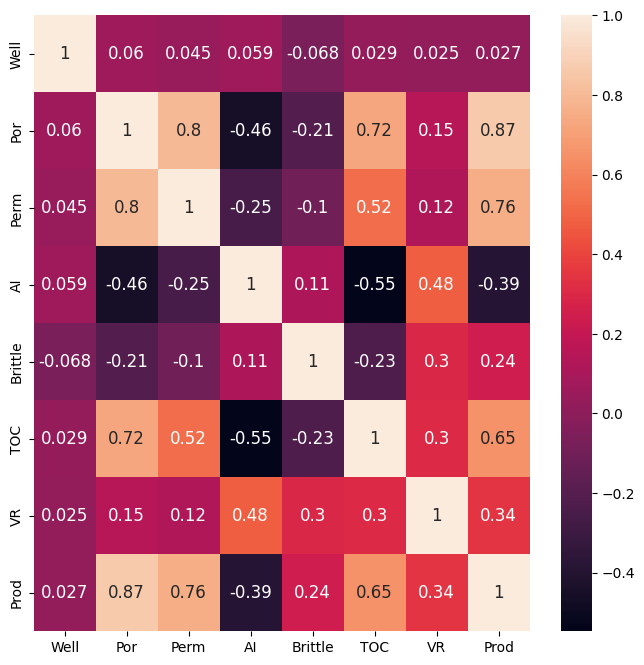

In [236]:
# Ваш код здесь

#Визулизируем матрицу корерляций
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 8))
sns.heatmap(data_log.corr(numeric_only=True), annot=True, annot_kws={'size': 12})

In [237]:
# Матрица корерляций в numpy массиве для аналитической работы

A = np.array(data_log.corr())

In [238]:
# Определяем ранг и определитель корреляционной матрицы

print('Ранг матрицы:',np.linalg.matrix_rank(A))
print('Определитель матрицы:',np.linalg.det(A))

Ранг матрицы: 8
Определитель матрицы: 0.0007431979972296826


> *Ваши выводы здесь*
### Выводы

> 1. Наблюдается высокая коллинеарность признаков **Por** и **Perm**, это говорит о линейной зависимости признаков
> 2. Определитель матрицы стремится к 0, этот фактор также говорит о линейной зависимости признаков

> Из - за этого модель регрессии может быть неустойчивой, коэффициенты w могут быть **прыгающими**

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [239]:
# Ваш код здесь
# Составляем матруцу факторов X и матрицу целевых признаков y
X = np.column_stack([np.ones(198), np.array(data_log.drop(['Prod'], axis=1))]) # Добавляем свободный член (np.ones)
y = np.array(data_log)[:, 7]

In [244]:
# создаём модель линейной регрессии
w_hat = np.linalg.inv(X.T@X)@X.T@y
print(np.round(A[7],4))
print(np.round(w_hat))

[ 0.0268  0.8662  0.7576 -0.3937  0.2388  0.6549  0.3441  1.    ]
[-1756.     0.   238.   542.  -312.    26.   -50.   688.]


> *Ваши выводы здесь*

### Вывод

> Коээфициент признака Well --> 0, что подтверждает наш вывод о том (см. 5.1), что признак не информативен.


### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

### а. Прогноз одного наблюдения

In [245]:
p = np.array([X[105]])
p

array([[  1.        , 107.        ,  13.48      ,   1.28370777,
          2.93      ,  55.3       ,   0.5       ,   1.7       ]])

In [246]:
# Ваш код здесь
prediction_1 = (p@w_hat)
print('prediction:', prediction_1)

prediction: [3806.7948627]


In [247]:
print('Absolute_error:', np.round(abs(y[105] - prediction_1),2))

Absolute_error: [83.63]


### б. Прогноз для всех наблюдений

In [248]:
prediction = (X@w_hat)
print('MAE:', round(metrics.mean_absolute_error(y, prediction),2))
print('MAPE: {:.2f} %'.format(round(metrics.mean_absolute_percentage_error(y, prediction)*100)))

MAE: 164.42
MAPE: 4.00 %


> *Ваши выводы здесь*

# Выводы

> 1. Обучена модель линейной регрессии аналитическим методом

> 2. Метрики:

        - AE  - 83.63

        - MAE - 164.42

        - MAPE  - 164.42

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [252]:
# Ваш код здесь
print(data.corr().iloc[7])
print(np.round(w_hat[1:8]))

Well       0.026817
Por        0.861910
Perm       0.727426
AI        -0.390835
Brittle    0.237155
TOC        0.654445
VR         0.323182
Prod       1.000000
Name: Prod, dtype: float64
[   0.  238.  542. -312.   26.  -50.  688.]


> *Ваши выводы здесь*

### Выводы

> Коээфициент веса предпоследнего признака *TOC* отрицательный, хотя корреляционный коэффициент положительный, это говорит о том, что данный коэффициент занижает вес признака TOС для нивелирования влияния признаков **Por, Perm, VR**, так как данные признаки имеют высокие положительный коэффициенты *w*

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [253]:
# Ваш код здесь
#Удаляем неинформативный признак Well и один из коллиниарных признаков (так как у Por корерляция с целевой переменной выше --> удаляем Perm)
df = data_log.drop(['Well', 'Perm'], axis=1)

<Axes: >

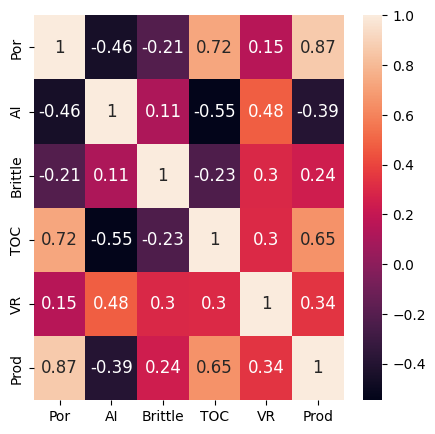

In [254]:
#матрица корреляций после удаления признаков
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, annot_kws={'size': 12})

In [255]:
X_new = np.column_stack([np.ones(198), np.array(df.drop(['Prod'], axis=1))])

w_hat = np.linalg.inv(X_new.T@X_new)@X_new.T@y
print(np.round(w_hat))

[-1901.   291.  -134.    29.    87.   399.]


In [256]:
prediction = X_new@w_hat
print('MAE:', round(metrics.mean_absolute_error(y, prediction),2))
print('MAPE: {:.2f} %'.format(round(metrics.mean_absolute_percentage_error(y, prediction)*100)))

MAE: 170.31
MAPE: 4.00 %


> *Ваши выводы здесь*

### Выводы

> - Направление коэффициентов **w** соответствуют корреляционной матрице
> - Удаление признаков не повлияло на метрики

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [257]:
# Ваш код здесь
model = LinearRegression(fit_intercept=False)
model.fit(X_new, y)
w_hat = np.round(model.coef_)
print(w_hat)

[-1901.   291.  -134.    29.    87.   399.]


In [258]:
prediction = model.predict(X_new)
print('MAE:', round(metrics.mean_absolute_error(y, prediction),2))
print('MAPE: {:.2f} %'.format(round(metrics.mean_absolute_percentage_error(y, prediction)*100)))

MAE: 170.31
MAPE: 4.00 %


> *Ваши выводы здесь*

### Вывод

> Коэффициенты, подобранные, моделью из библиотеки scikit-learn соответствуют аналитическому решению. метрики не изменились

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [259]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [260]:
# Ваш код здесь
# Так как все признаки распределены нормально, можем воспользоваться стандартизацией
scaler = StandardScaler()
X_scal = scaler.fit_transform(X_new[:, 1:5])

# Формирование полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scal)

# Количество признаков
X_poly.shape[1]

34

In [261]:
lr = LinearRegression()

# оцениваем качество модели на кросс-валидации, метрика — MAPE, метрика — MAE
cv_results = cross_validate(lr, X_poly, y, scoring=['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'], cv=5, return_train_score=True)

# Метрка MAPE
print('MAPE на тренировочных фолдах: {:.2f} %'.format(round(abs(cv_results['train_neg_mean_absolute_percentage_error'].mean()*100))))
print('MAPE на валидационных фолдах: {:.2f} %'.format(round(abs(cv_results['test_neg_mean_absolute_percentage_error'].mean()*100))))

# Метрка MAE
print('MAE на тренировочных фолдах: {:.2f}'.format(round(abs(cv_results['train_neg_mean_absolute_error'].mean()))))
print('MAE на валидационных фолдах: {:.2f}'.format(round(abs(cv_results['test_neg_mean_absolute_error'].mean()))))

MAPE на тренировочных фолдах: 2.00 %
MAPE на валидационных фолдах: 2.00 %
MAE на тренировочных фолдах: 70.00
MAE на валидационных фолдах: 99.00


> *Ваши выводы здесь*

## Выводы:

> После формирования полиномиальных признаков, метрики MAPE и MAE улучшились
> Так как датасет имеет малую величину, расхождения между тренировочной и валидационнйо моделями незначительное

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [262]:
from sklearn.model_selection import RandomizedSearchCV

In [263]:
# Ваш код здесь

param_distributions = {
    'alpha': list(np.linspace(0.01, 1, 25, dtype=float))  # alpha = сила регуляризации
}
            
random_search = RandomizedSearchCV(
    estimator=Lasso(),  # Используем Lasso вместо LinearRegression
    param_distributions=param_distributions,
    cv=5, 
    n_iter = 15, 
    n_jobs = -1
)  
%time random_search.fit(X_poly, y) 

# Лучшая модель после поиска
best_model = random_search.best_estimator_

# Оценка лучшей модели на кросс-валидации
cv_results = cross_validate(
    best_model,
    X_poly,
    y,
    scoring=['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
    cv=5,
    return_train_score=True
)

# Лучший параметр
print('best_alpha:', round(best_model.alpha,3))

# Вывод метрик
print('MAPE на тренировочных фолдах: {:.2f} %'.format(abs(cv_results['train_neg_mean_absolute_percentage_error'].mean() * 100)))
print('MAPE на валидационных фолдах: {:.2f} %'.format(abs(cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100)))

print('MAE на тренировочных фолдах: {:.2f}'.format(abs(cv_results['train_neg_mean_absolute_error'].mean())))
print('MAE на валидационных фолдах: {:.2f}'.format(abs(cv_results['test_neg_mean_absolute_error'].mean())))

CPU times: total: 31.2 ms
Wall time: 6.05 s
best_alpha: 1.0
MAPE на тренировочных фолдах: 1.68 %
MAPE на валидационных фолдах: 2.31 %
MAE на тренировочных фолдах: 71.30
MAE на валидационных фолдах: 94.55


> *Ваши выводы здесь*

### Вывод

> Модель с подбором гиперпараметров немного лучше справилась с задачей, при этом расхождение МАЕ между тренировочнйо и Валидационной моделью уменьшилось, а **МАРЕ - увеличилась**

> ***Это может быть связано с тем, что в модели 1 - Ошибки равномерно распределены (±), а модель 2 (с подбором гиперпараметров) - могла лучше подстроиться под тренировочные данные, но хуже обобщаться.***

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [212]:
# Ваш код здесь

param_distributions = {
    'alpha': list(np.linspace(0.01, 1, 25, dtype=float))  # alpha = сила регуляризации
}
            
random_search = RandomizedSearchCV(
    estimator=Ridge(),  # Используем Lasso вместо LinearRegression
    param_distributions=param_distributions,
    cv=5, 
    n_iter = 15, 
    n_jobs = -1
)  
%time random_search.fit(X_poly, y) 

# Лучшая модель после поиска
best_model = random_search.best_estimator_

# Оценка лучшей модели на кросс-валидации
cv_results = cross_validate(
    best_model,
    X_poly,
    y,
    scoring=['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
    cv=5,
    return_train_score=True
)

# Лучший параметр
print('best_alpha:', round(best_model.alpha,3))

# Вывод метрик
print('MAPE на тренировочных фолдах: {:.2f} %'.format(abs(cv_results['train_neg_mean_absolute_percentage_error'].mean() * 100)))
print('MAPE на валидационных фолдах: {:.2f} %'.format(abs(cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100)))

print('MAE на тренировочных фолдах: {:.2f}'.format(abs(cv_results['train_neg_mean_absolute_error'].mean())))
print('MAE на валидационных фолдах: {:.2f}'.format(abs(cv_results['test_neg_mean_absolute_error'].mean())))

CPU times: total: 31.2 ms
Wall time: 37 ms
best_alpha: 0.918
MAPE на тренировочных фолдах: 1.71 %
MAPE на валидационных фолдах: 2.40 %
MAE на тренировочных фолдах: 72.24
MAE на валидационных фолдах: 98.32


> *Ваши выводы здесь*

### Выводы:

> Качество модели с L2-регуляризацией принципиально не изменилось

> best alpha = 0.918

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [218]:
# Ваш код здесь

param_distributions = {
    'alpha': list(np.linspace(0.01, 1, 25, dtype=float)),  # alpha = сила регуляризации
    'l1_ratio': list(np.linspace(0.1, 1, 25, dtype=float)) #  доля L1-регуляризации
}
            
random_search = RandomizedSearchCV(
    estimator= ElasticNet(),  # Используем ElasticNet
    param_distributions=param_distributions,
    cv=5, 
    n_iter = 15, 
    n_jobs = -1
)  
%time random_search.fit(X_poly, y) 

# Лучшая модель после поиска
best_model = random_search.best_estimator_

# Оценка лучшей модели на кросс-валидации
cv_results = cross_validate(
    best_model,
    X_poly,
    y,
    scoring=['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
    cv=5,
    return_train_score=True
)

# Лучший параметр
print('best_alpha:', round(best_model.alpha,3))
print('best_l1_ratio:', round(best_model.l1_ratio,3))

# Вывод метрик
print('MAPE на тренировочных фолдах: {:.2f} %'.format(abs(cv_results['train_neg_mean_absolute_percentage_error'].mean() * 100)))
print('MAPE на валидационных фолдах: {:.2f} %'.format(abs(cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100)))

print('MAE на тренировочных фолдах: {:.2f}'.format(abs(cv_results['train_neg_mean_absolute_error'].mean())))
print('MAE на валидационных фолдах: {:.2f}'.format(abs(cv_results['test_neg_mean_absolute_error'].mean())))

CPU times: total: 15.6 ms
Wall time: 71.7 ms
best_alpha: 0.505
best_l1_ratio: 1.0
MAPE на тренировочных фолдах: 1.67 %
MAPE на валидационных фолдах: 2.37 %
MAE на тренировочных фолдах: 70.75
MAE на валидационных фолдах: 96.29


> *Ваши выводы здесь*

### Выводы:

> Качество гибридной модели ElasticNet принципиально не изменилось

> best alpha = 0.505

> Также можно заметить, что при подборе гиперпараметров **best_l1_ratio = 1**, т.е. мы получили аналогичную модель с L2 - регуляризацией

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

### Сводная таблица резульатов:

Схема:
1. Наименование: тип модели обучения 

- А - аналитический метод;
- lr - линейная регрессия;
- lr_poly - линейная регрессия c полиномилаьными стандартизироваными признаками;

**Во всех моделях, представленных в таблице, удалены неинформативные и мультиколлинеарные признаки*

2. Тип регуляризации:

- l1;
- l2;
- ElasticNet;

3. Кросс_валидация:

- 0 - нет;
- 1- есть;

4. Подбор гиперпараметров:

- 0 - нет;
- 1- есть;

5. MAPE_train [%] - средняя абсолютная процентная ошибка тренировочной выборки

6. MAPE_val [%] - средняя абсолютная процентная ошибка валидационной выборки

7. MAE_train - средняя абсолютная ошибка тренировочной выборки

8. MAE_val - средняя абсолютная ошибка валидационной выборки

In [224]:
# Ваш код здесь

report = pd.DataFrame({
    'Наименование': ['А', 'Lr', 'Lr_poly', 'Lr_poly', 'Lr_poly', 'Lr_poly'],
    'Тип регуляризации': [np.nan, np.nan, np.nan, 'l1', 'l2', 'Elastic'],
    'Кросс_валидация': [0, 0, 1, 1, 1, 1],
    'Подбор гиперпараметров': [0, 0, 0, 1, 1, 1],
    'MAPE_train [%]': [4, 4, 2, 1.68, 1.71, 1.67],
    'MAPE_val [%]': [np.nan, np.nan, 2, 2.31, 2.40, 2.37],
    'MAE_train': [170.31, 170.31, 70.00, 71.30, 72.24, 70.75],
    'MAE_val': [np.nan, np.nan, 99.00, 95.55, 98.32, 96.29],
})

report

,Наименование,Тип регуляризации,Кросс_валидация,Подбор гиперпараметров,MAPE_train [%],MAPE_val [%],MAE_train,MAE_val
0,А,NaN,0,0,4.00,NaN,170.31,NaN
1,Lr,NaN,0,0,4.00,NaN,170.31,NaN
2,Lr_poly,NaN,1,0,2.00,2.00,70.00,99.00
3,Lr_poly,l1,1,1,1.68,2.31,71.30,95.55
4,Lr_poly,l2,1,1,1.71,2.40,72.24,98.32
5,Lr_poly,Elastic,1,1,1.67,2.37,70.75,96.29


> *Ваши выводы здесь*

# Итог:

1. Выполнен разведывательный анализ набора данных, данные проверен на нормальность распределения признаков, исключены выбросы.
2. Построена корреляционная матрица признаков.
3. Исключены неинформативные и мультиколлинеарные признаки.
4. Все модели обучены через линейную регрессию, разыми методами (см. таблицу).
5. Проинтерпертированы резульата (см. промежуточные выводы).


## Итоговый вывод:

1. Для наиболее точного предсказания объёма добычи газа, необходимо использовать модели со стандартизироваными  полиномиальными признаками ***Lr_poly с l1 - регуляризацией***

2. Почему:

- Лучшая MAE_val (95.55).

- Низкая MAPE_val (2.31%) — разница c [2] минимальна.

- Регуляризация L1 помогает в отсечении лишнего — меньше переобучения.